Я - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев наш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Мне нужно разобраться в причинах этой ситуации.

У меня в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Мне предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

__Описание данных__

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовка их к анализу

Импортируем нужные библиотеки и погрузим файлы в отведенные для них переменные

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [1]:
try: 
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except: 
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

NameError: name 'pd' is not defined

Напишем функцию, которая выдаст краткую информацию о наших данных: инфо, первые 10 строк и количество дубликатов

In [5]:
def information(data):
    display(data.info())
    display(data.head(10))
    print('Выявлено дубликатов:', data.duplicated().sum())
    print('Выявлено пропусков:')
    print(round((data.isna().mean()*100),2))

### Информация о таблице visits

In [6]:
information(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


Выявлено дубликатов: 0
Выявлено пропусков:
User Id          0.0
Region           0.0
Device           0.0
Channel          0.0
Session Start    0.0
Session End      0.0
dtype: float64


Сразу переименуем колонки: приведём к нижнему змеиному регистру; и приведём дату к типу datetime.

In [7]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Проверим наличие скрытых дубликатов в названиях каналов, девайсов и регионов.

In [8]:
visits['channel'].value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

In [9]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [10]:
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

Сразу можно увидеть, что больше всего пользователей у нас из США, на айфонах и пришедших органическим путём.

### Информация о таблице orders

In [11]:
information(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


Выявлено дубликатов: 0
Выявлено пропусков:
User Id     0.0
Event Dt    0.0
Revenue     0.0
dtype: float64


Переименуем колонки и приведём дату к нужному формату.

In [12]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Переименуем колонки и приведём дату к нужному формату. Посмотрим, нет ли неявных дубликатов в названии каналов привлечения пользователей.

### Информация о таблице costs

In [13]:
information(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


Выявлено дубликатов: 0
Выявлено пропусков:
dt         0.0
Channel    0.0
costs      0.0
dtype: float64


In [14]:
costs.columns = ['dt', 'channel', 'costs']
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
costs['channel'].value_counts()

YRabbit               180
lambdaMediaAds        180
AdNonSense            180
RocketSuperAds        180
MediaTornado          180
LeapBob               180
OppleCreativeMedia    180
TipTop                180
FaceBoom              180
WahooNetBanner        180
Name: channel, dtype: int64

### Вывод

Данные подготовлены к дальнейшей работе. Уже по первому взгляду на них можно сказать, что больше всего пользователей из США и привлечённых органическим путём.

## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии


Загрузим все функции, которые будем использовать при анализе данных.

### Функция для создания таблицы пользователей 

In [16]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция рассчёта конверсии

In [17]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция рассчёта LTV

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция рассчёта удержания

In [19]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для сглаживания фрейма

In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [21]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для визуализации конверсии

In [22]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Создадим таблицу пользовательских профилей с помощью функции get_profiles().

In [24]:
profiles = get_profiles(visits, orders, None, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей.

In [25]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(min_date, max_date)

2019-05-01 2019-10-27


Первая дата - 5 мая, последняя - 27 октября. Зададим момент и горизонт анализа

In [26]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14

Изобразим наглядно, каково соотношение по странам для пользователей.

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

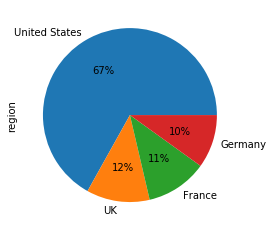

In [27]:
visits['region'].value_counts().plot(kind='pie', autopct='%1.f%%')
visits['region'].value_counts()

In [28]:
by_region = profiles.pivot_table(index=['region'], values=['user_id', 'payer'],
                              aggfunc={'user_id':'nunique', 'payer':'sum'})
by_region.columns = ['customers', 'users']
by_region['% payer'] = by_region['customers'] / by_region['users'] 
by_region = by_region.sort_values(by = '% payer', ascending=False)
by_region.style.format({'% payer': '{:.2%}'})

,customers,users,% payer
region,,,
United States,6902,100002,6.90%
Germany,616,14981,4.11%
UK,700,17575,3.98%
France,663,17450,3.80%


Создадим сводную таблицу, в которой отобразим процент платящих пользователей по разным видам устройств, с которых они сидят.

In [29]:
by_device = profiles.pivot_table(index=['device'], values=['user_id', 'payer'],
                              aggfunc={'user_id':'nunique', 'payer':'sum'})
by_device.columns = ['customers', 'users']
by_device['% payer'] = by_device['customers'] / by_device['users'] 
by_device = by_device.sort_values(by = '% payer', ascending=False)
by_device.style.format({'% payer': '{:.2%}'})

,customers,users,% payer
device,,,
Mac,1912,30042,6.36%
iPhone,3382,54479,6.21%
Android,2050,35032,5.85%
PC,1537,30455,5.05%


Теперь создадим сводную таблицу, в которой отобразим процент платящих пользователей по разным видам каналов привлечения, с которых они пришли.

In [30]:
by_channel = profiles.pivot_table(index=['channel'], values=['user_id', 'payer'],
                              aggfunc={'user_id':'nunique', 'payer':'sum'})
by_channel.columns = ['customers', 'users']
by_channel['% payer'] = by_channel['customers'] / by_channel['users'] 
by_channel = by_channel.sort_values(by = '% payer', ascending=False)
by_channel.style.format({'% payer': '{:.2%}'})

,customers,users,% payer
channel,,,
FaceBoom,3557,29144,12.20%
AdNonSense,440,3880,11.34%
lambdaMediaAds,225,2149,10.47%
TipTop,1878,19561,9.60%
RocketSuperAds,352,4448,7.91%
WahooNetBanner,453,8553,5.30%
YRabbit,165,4312,3.83%
MediaTornado,156,4364,3.57%
LeapBob,262,8553,3.06%


### Вывод

Как было видно в самом начале, пользователей из Америки больше всех. 67% - это две трети всех пользователей. То есть каждые два из трёх пользователей будут из Америки. Много. Доля платящих среди американцев тоже самая большая: почти 7%.

По разным устройствам сильной разницы в платёжеспосоности пользователей нет: 5% для самого маленького показателя и 6% - для самого большого. Несмотря на то, что с айфонов сидит преобладающее количество пользователей их показатель платящих пользователей даже не самый высокий.

А вот для каналов привлечения видна существенная разница: больше всего пользователей приходит органически, но из них конвертируются в платежи всего 2%. На втором месте по количеству пользователей FaceBoom с 29 тысячами пользователей и рекордными 12% платящих. На третьем месте по количеству привлечённых пользователей - TipTop с 9,6% платящих.

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Посмотрим, сколько всего денег было потрачено на маркетинг за всё время наблюдений.

In [31]:
costs.sum()

costs    105497.3
dtype: float64

Построим график и посмотрим, как распределялись средства по месяцам.

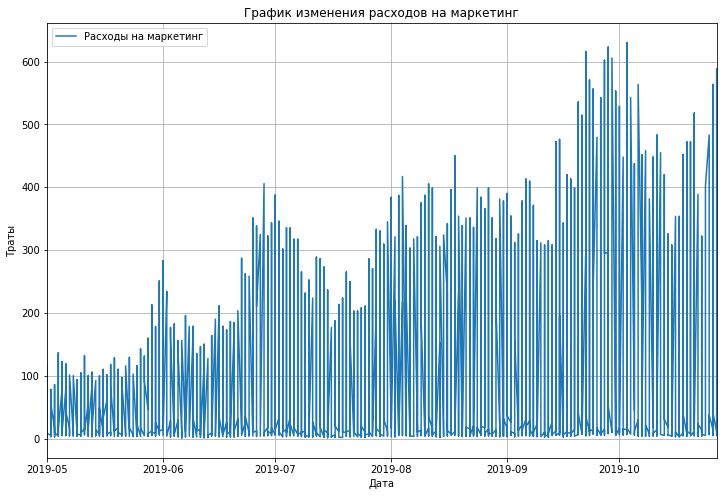

In [32]:
costs.plot(y='costs',
           x='dt',
           figsize=(12, 8), 
           grid=True,         
           label='Расходы на маркетинг',                      
           legend=True)
           
plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

Судя по графику, с мая затраты на рекламу стали увеличиваться. В середине месяцев видна просадка по финансированию, а к концам и началам месяцев - рост. К октябрю рост финансирования достиг наибольшего значения и превысил 600.

Построим и визуализируем таблицу отображающую распределение затрат на маркетинг на отдельные каналы привлечения.

In [33]:
cost_by_channel = pd.DataFrame()
cost_by_channel['costs'] = costs.groupby('channel')['costs'].sum()
cost_by_channel['%'] = ((cost_by_channel['costs'] / costs['costs'].sum()) * 100)
cost_by_channel.sort_values(by='%', ascending=False).style.format({'%': '{:.2f}%', 'payer_share': '{:.2f}%'})

,costs,%
channel,,
TipTop,54751.3,51.90%
FaceBoom,32445.6,30.75%
WahooNetBanner,5151,4.88%
AdNonSense,3911.25,3.71%
OppleCreativeMedia,2151.25,2.04%
RocketSuperAds,1833,1.74%
LeapBob,1797.6,1.70%
lambdaMediaAds,1557.6,1.48%
MediaTornado,954.48,0.90%


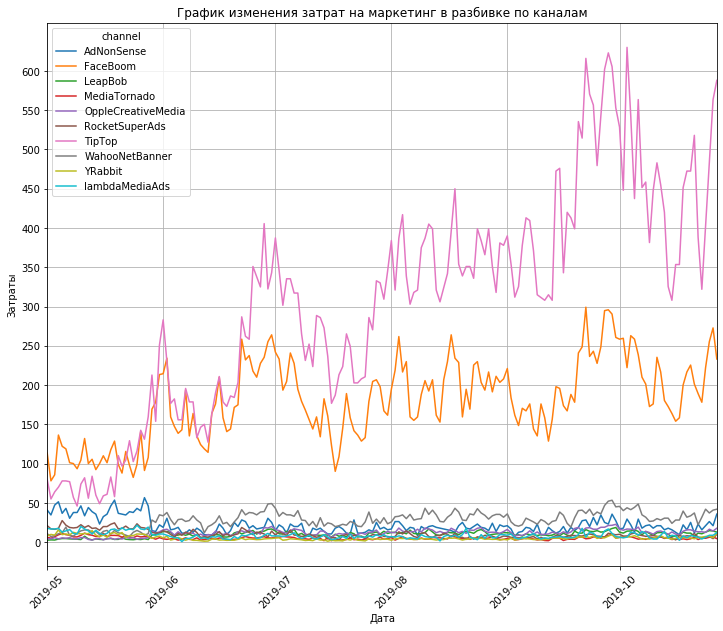

In [34]:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10), 
           grid=True, 
           rot=45,        
           label='Каналы',                       
           legend=True
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('График изменения затрат на маркетинг в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

In [35]:
filtered_data

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
2019-05-01,40.95,113.3,2.52,6.24,4.25,21.060,80.0,10.8,8.10,17.6
2019-05-02,34.65,78.1,2.94,5.04,4.25,16.965,55.0,7.2,9.90,16.8
2019-05-03,47.25,85.8,2.73,6.96,5.75,16.380,64.0,8.4,9.00,16.8
2019-05-04,51.45,136.4,3.99,9.36,4.25,17.550,70.0,10.8,15.60,17.6
2019-05-05,36.75,122.1,4.62,11.04,5.50,27.495,78.0,12.0,9.60,12.8
...,...,...,...,...,...,...,...,...,...,...
2019-10-23,15.75,178.2,10.71,5.28,13.25,5.525,322.0,31.8,6.48,4.0
2019-10-24,21.00,222.2,12.81,5.04,12.50,5.850,402.5,42.0,7.29,6.4
2019-10-25,26.25,255.2,14.70,6.24,16.50,7.150,483.0,37.2,7.56,8.8


По графику видно, что наибольшее финансирования получает TipTop, на втором месте FaceBoom. Затраты на эти два канала значительно превышают затраты на все остальные каналы привлечения. Причём, если затраты на все остальные каналы в целом со временем не меняются, держатся на каком-то определённом уровне, то затраты на TipTop со временем только растут. И как раз расходы на этот канал и превышают 600 в октябре.


Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [33]:
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Удалим из наших данных с профилями пользователей профили людей, пришедших органическим путём.

In [34]:
profiles = profiles.query('channel != "organic"')

In [35]:
cac = profiles['acquisition_cost'].mean()
cac

1.1274813239427588

Как было видно напредыдущем графике, трафик с TipTop самый дорогой. Он превышает затраты на своего ближайшего конкурента FaceBoom на 250%.

## Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишем проблемы, которые обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. При решении этого шага будем считать, что мы смотрите данные 1-го ноября 2019 года и что в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируем общую окупаемость рекламы

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

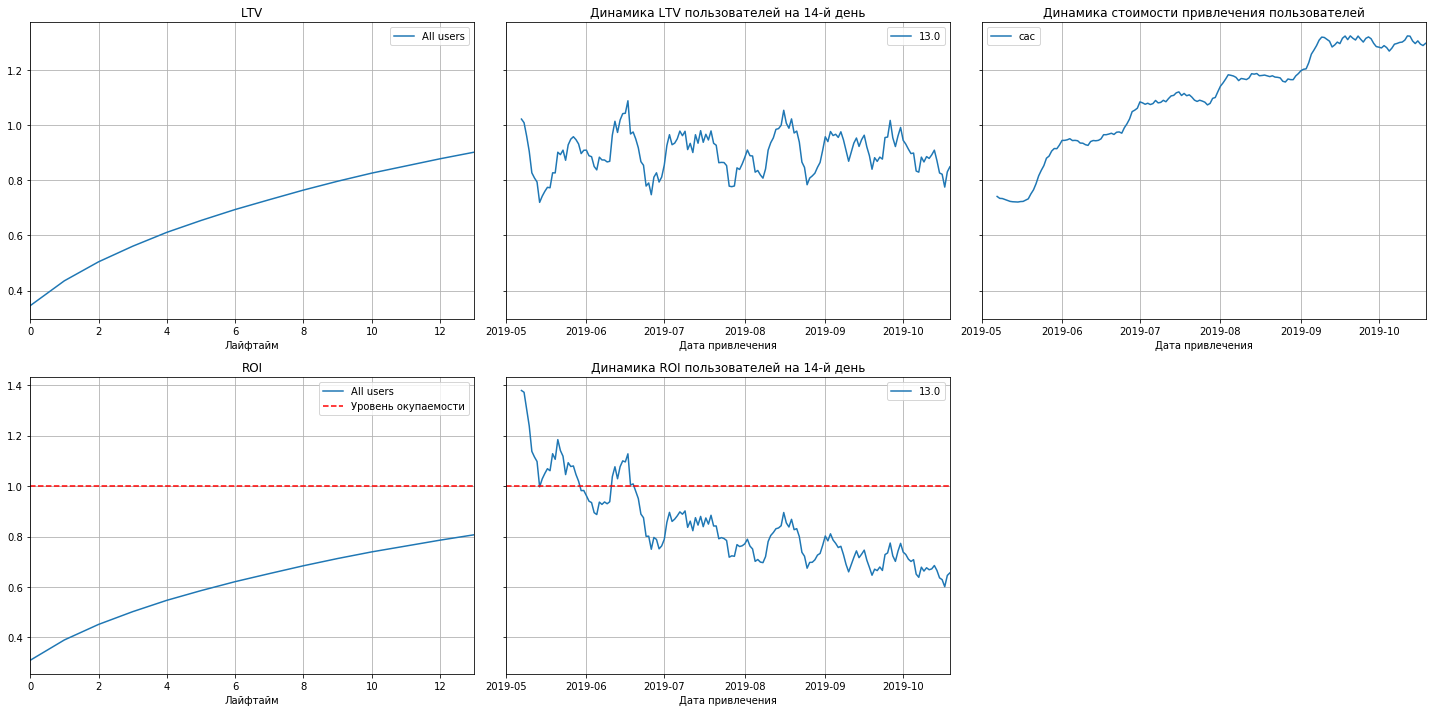

In [36]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

Реклама не окупается. Даже к концу второй недели окупаемость еле дотягивает до 80%

CAC не стабилен. Получается, расходы на рекламу увеличиваются. В общем-то, мы это видели на предыдущих графиках.

На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

ROI в течение анализируемого периода падает. До середины июня он ещё держится выше уровня окупаемости, а к ноябрю падает до 60%.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

Передадим параметру dimensions значение device

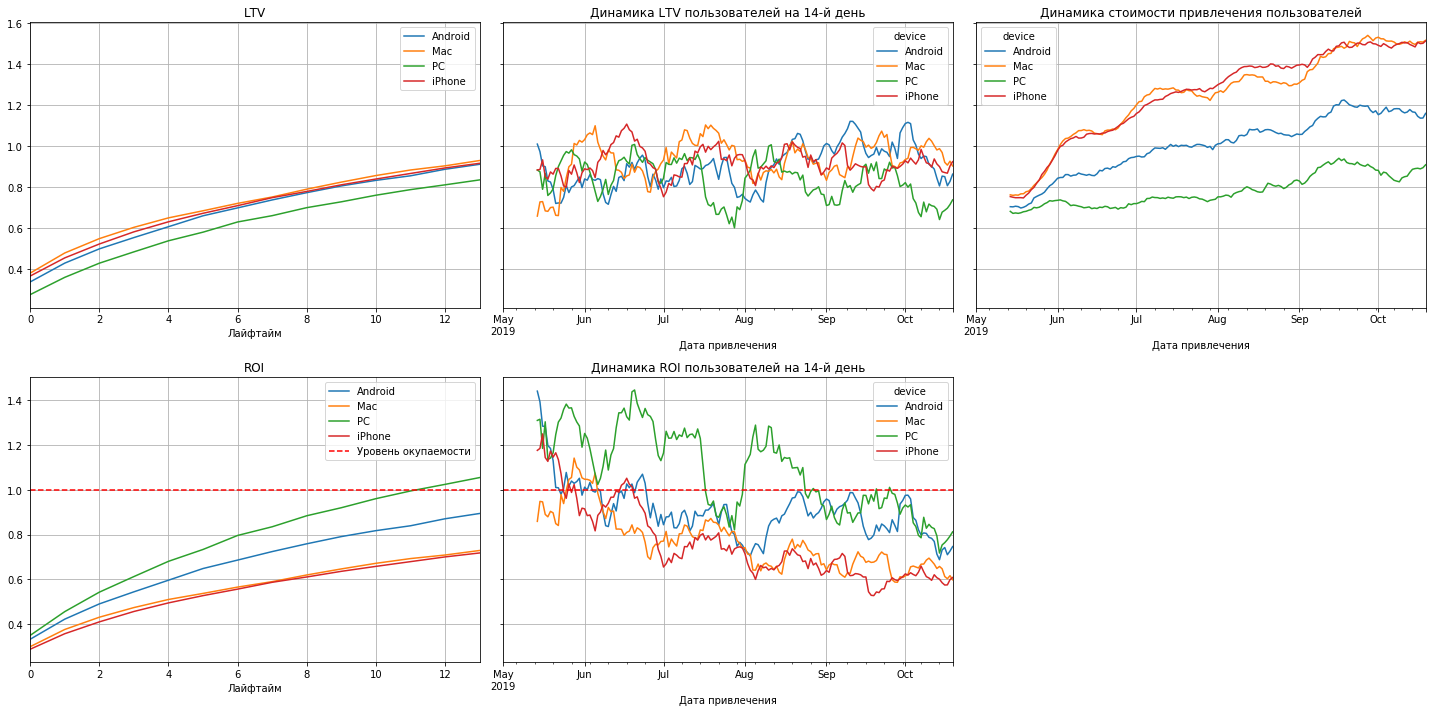

In [37]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:

LTV пользователей PC стабильно ниже, чем длявсех остальных пользователей. Но и стоимость их привлечения со временем почти не увеличивается. К концу второй недели владельцы PC единственные выходят на уровень окупаемости. И они единственные, кто в течение всего периода окупаются.

Для пользователей всех остальных устройств всё печальнее. Особенно для пользователей Mac и iPhone. Их уровень окупаемости стабильно держится на 60% с июля месяца, хотя в мае владельцы айфонов ещё окупались, как и владельцы андроид. А вот с июня они все устремились вниз.

Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()

Вледельцы андроид в течение всего периода кроме августа и октября практически выходят на уровень окупаемости, немного до него не дотягивают.

Стоит обратить внимание на пользователей Mac и iPhone. Затраты на их привлечение растут, а окупаемость падает.

Узнаем, в чём причина: в низкой конверсии или низком удержании.
Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().

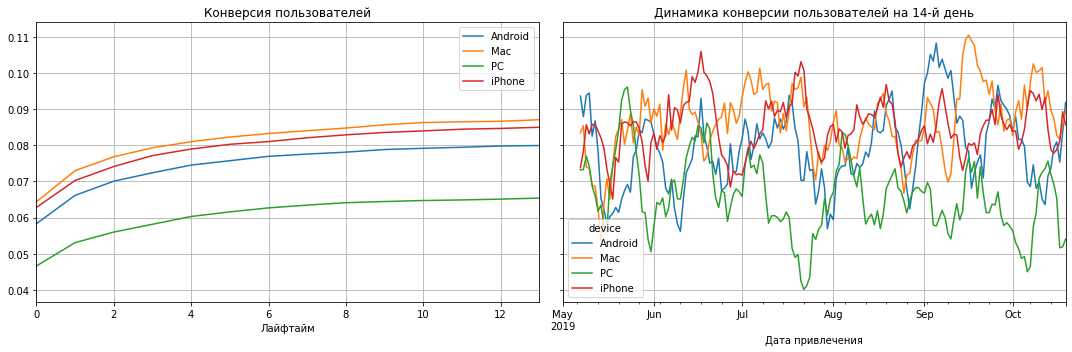

In [38]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи Mac, Android и iPhone конвертируются хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

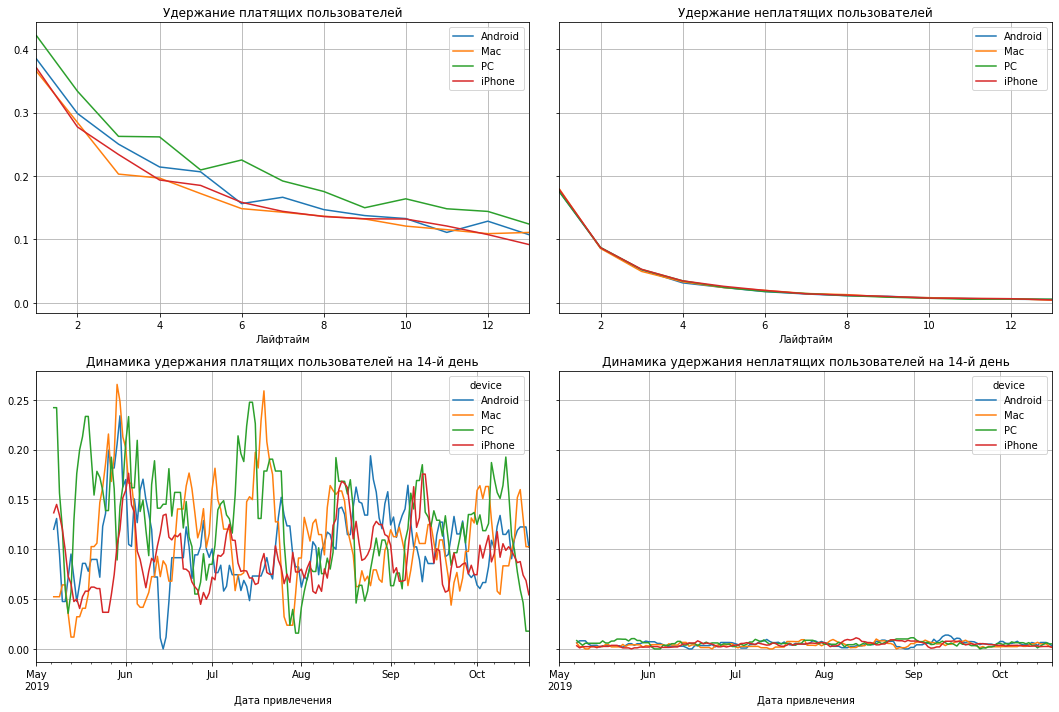

In [39]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Лучше всего из платящих пользователей удерживаются пользователи PC и Android, а хуже всего - пользователи Mac и iPhone

### Проанализируем окупаемость рекламы с разбивкой по странам

Передадим параметру dimensions значение region

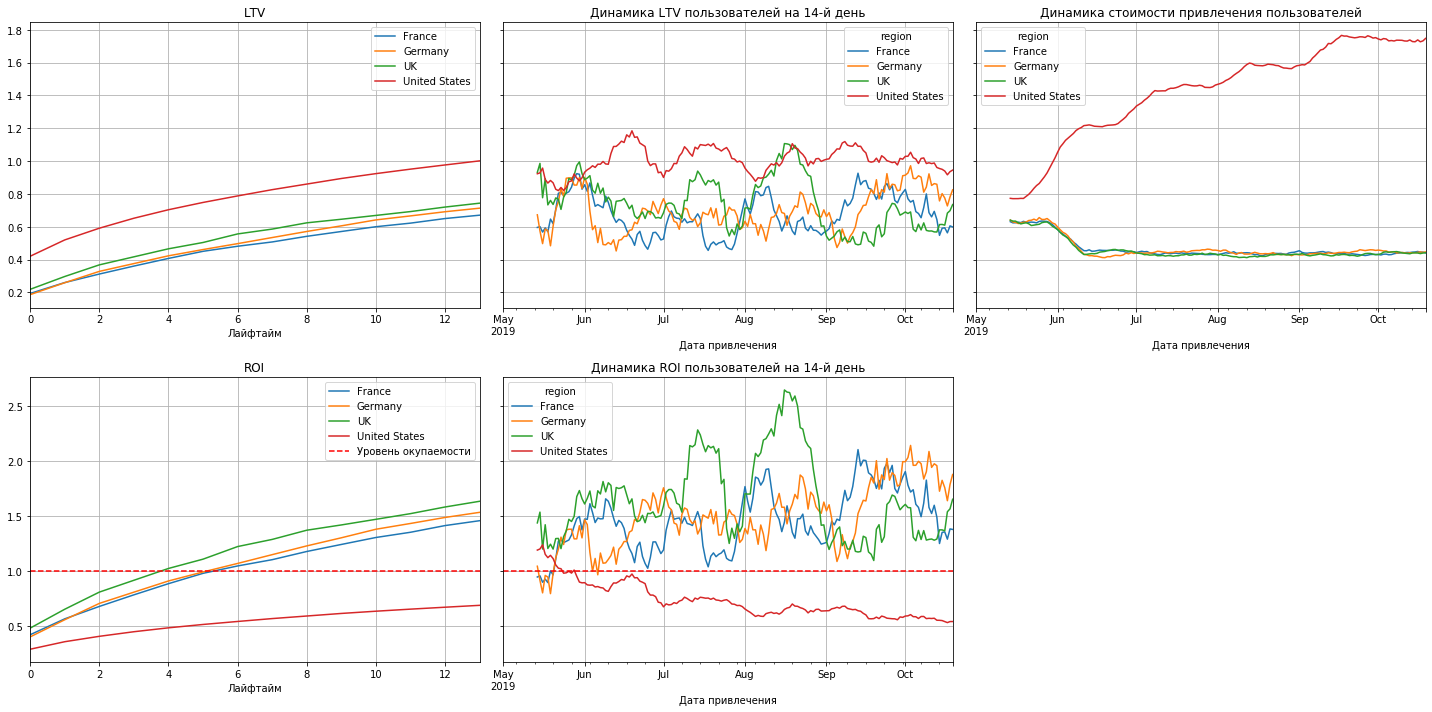

In [40]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Ого! Оказывается, не окупаются только пользователи из США! И растут только затраты на их привлечение, тогда как затраты на привлечение остальных пользователей падает. Что-то не так с пользователями из США.

LTV всё так же подвержен сезонности, но стабилен.

Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()

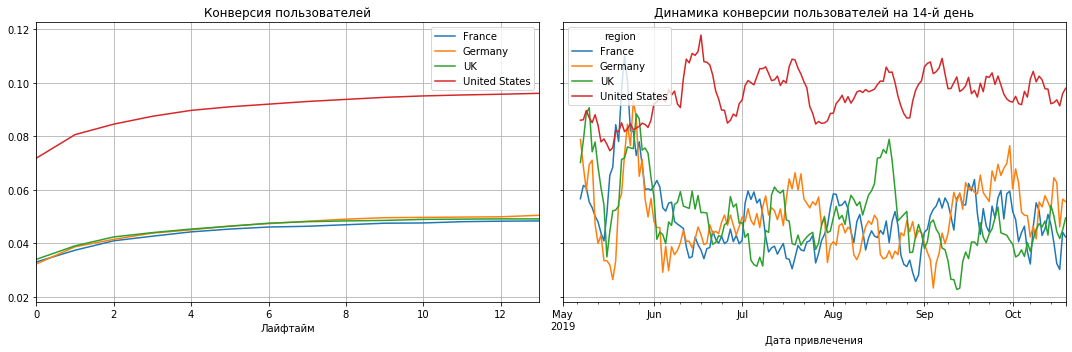

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графику, пользователи из Америки постоянно конвертируются хорошо.

Посмотрим на удержание 

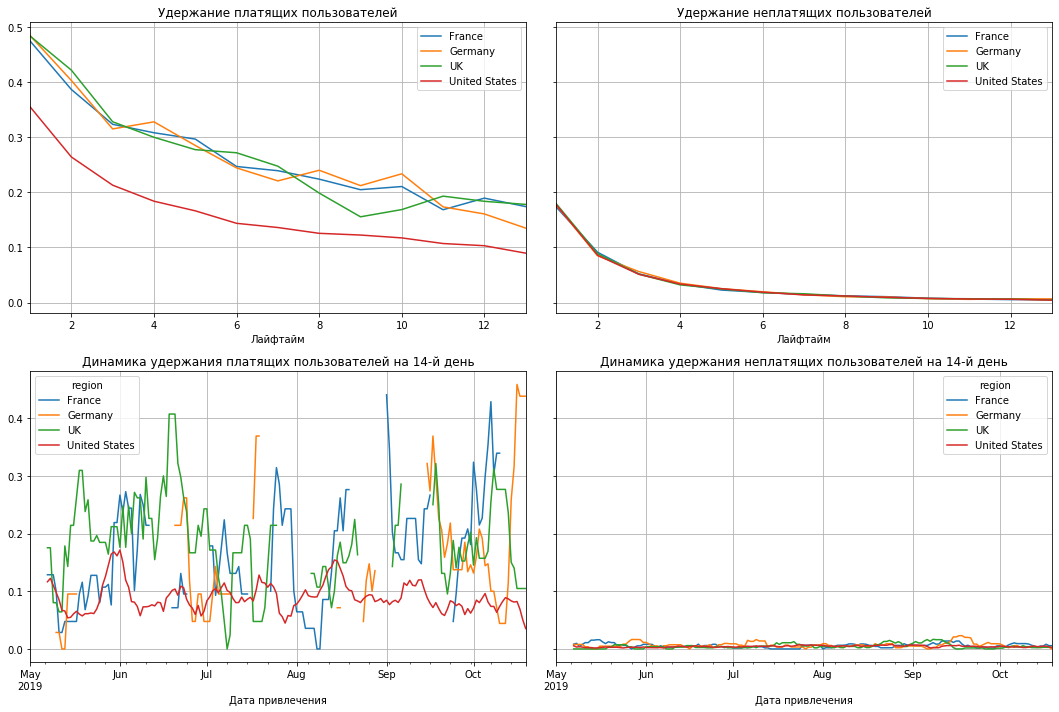

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графику видно, что пользователи из США удерживаются значительно хуже, чем пользователи из других стран.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Теперь проверим источники привлечения. Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

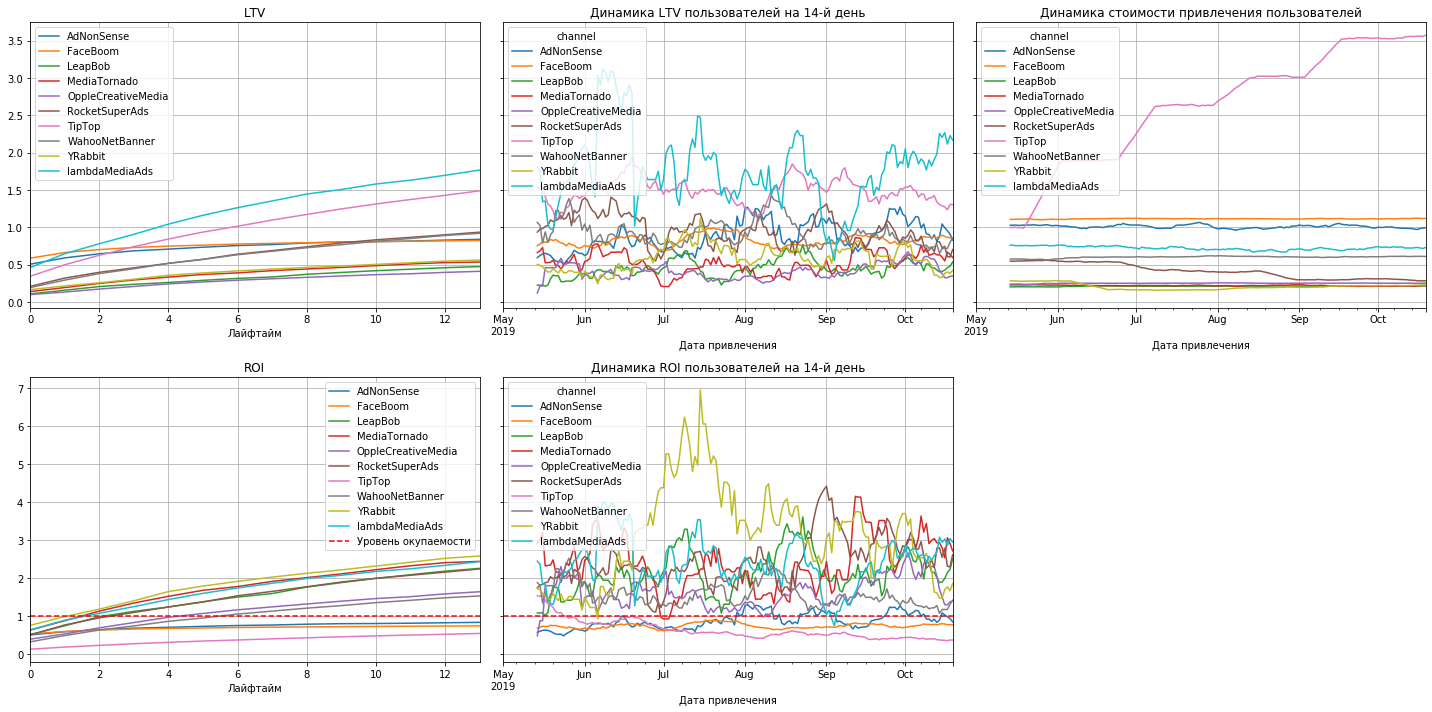

In [43]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Делаем выводы из графиков:

Очень высокая стоимость привлечения пользователей из TipTop. Очень большая, особенно по сравенению с тем, что стоимость привлечения пользователей из всех других каналов примерно одинаковая.

Не окупаются пользователи, привлеченные из каналов FaceBoom, TipTop и AdNonSense.

Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок.

Посмотрим конверсию

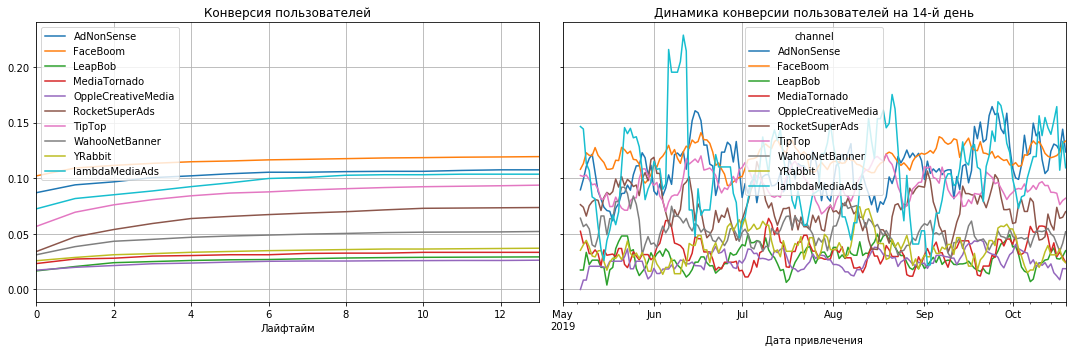

In [44]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

В топе конверсии FaceBoom, AdNonSense и lambdaMediaAds. Получается, что затраты на TipTop не соразмерны конверсии пользователей.

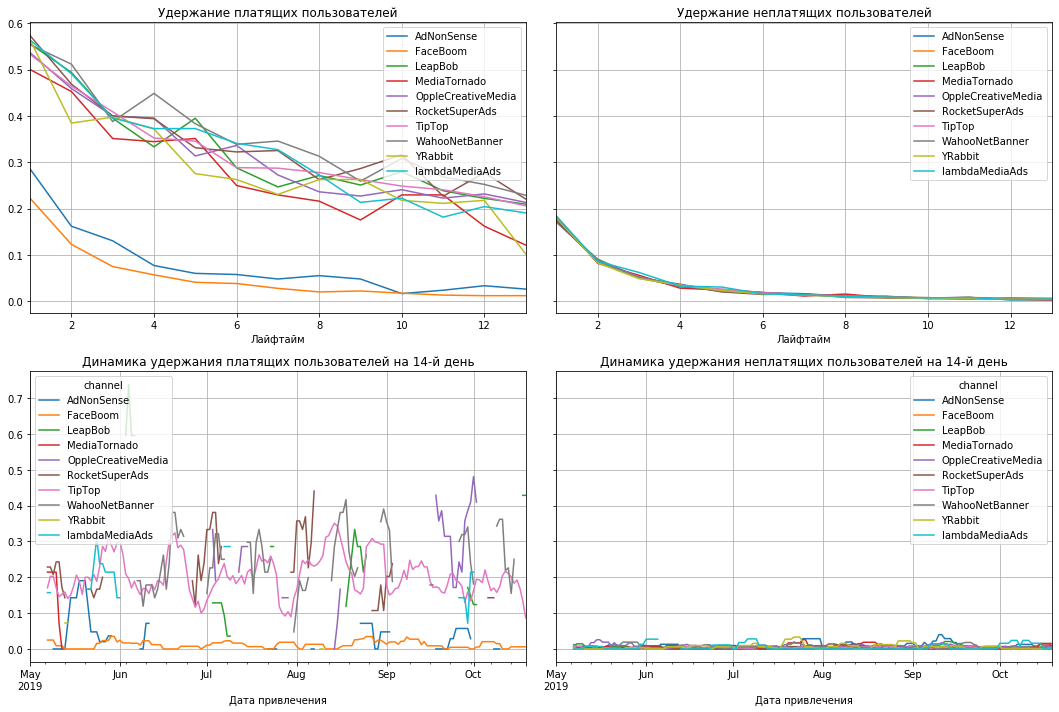

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Очень плохо удерживаются пользователи FaceBoom и AdNonSense.

Рассмотрим всё то же самое отдельно для США. Выделим из всех профилей те, которые принадлежат к Америке.

In [46]:
usa_profiles = profiles.query('region == "United States"')

Проверим источники привлечения.

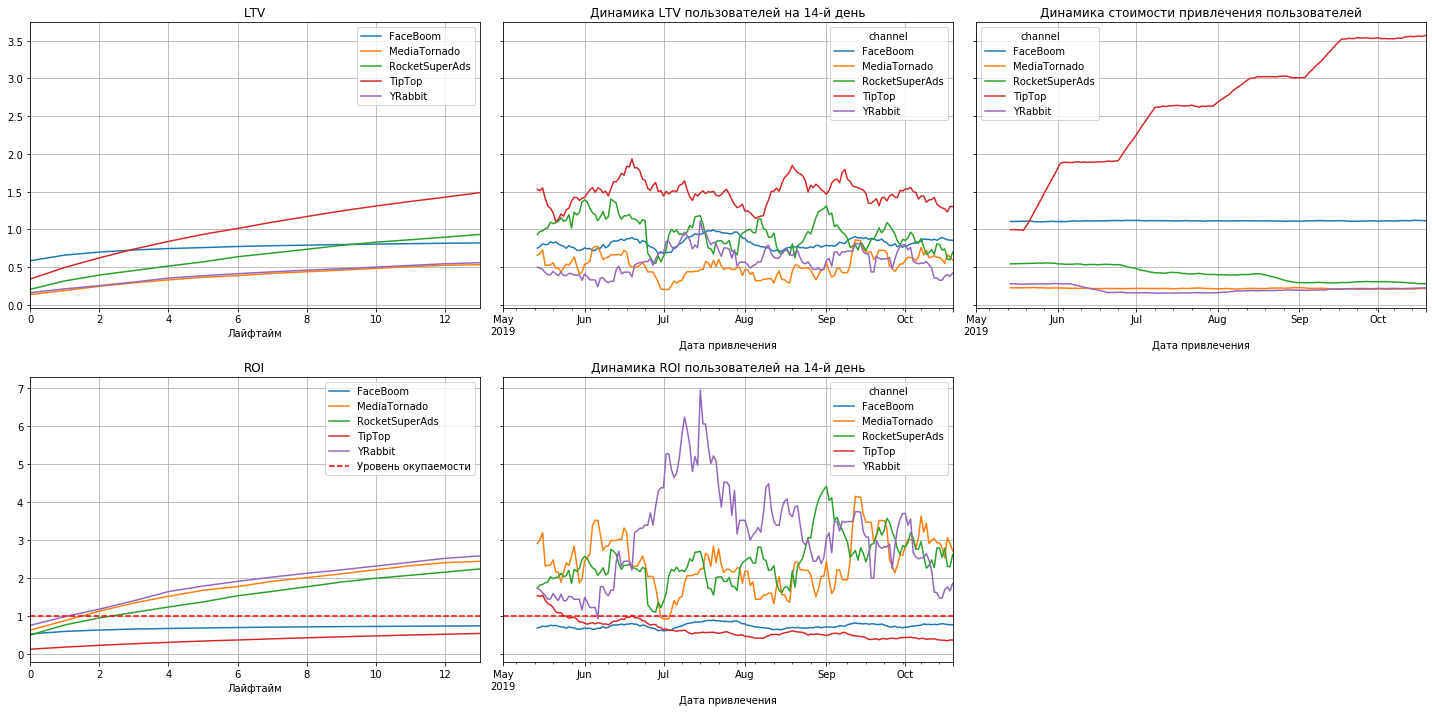

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Здесь в целом повторяется картина, характерная для общих графиков: LTV стабилен; 

стоимость привлечения пользователей из TipTop в 3.5 раза выше, чем стоимость привлечения пользователей из других каналов;

FaceBoom и TipTop не окупаются.

Посмотрим, что с конверсией.

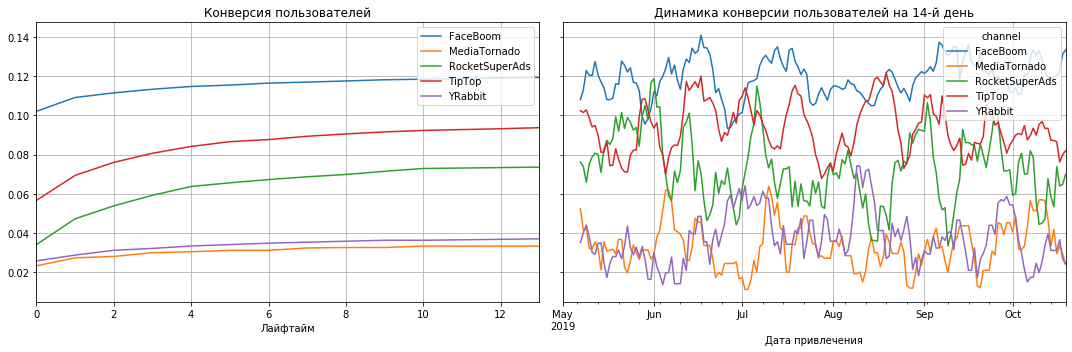

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Очень низкая конверсия у MediaTornado и YRabbit. Остальные держатся получше. FaceBoom вообще в этом плане самые молодцы.

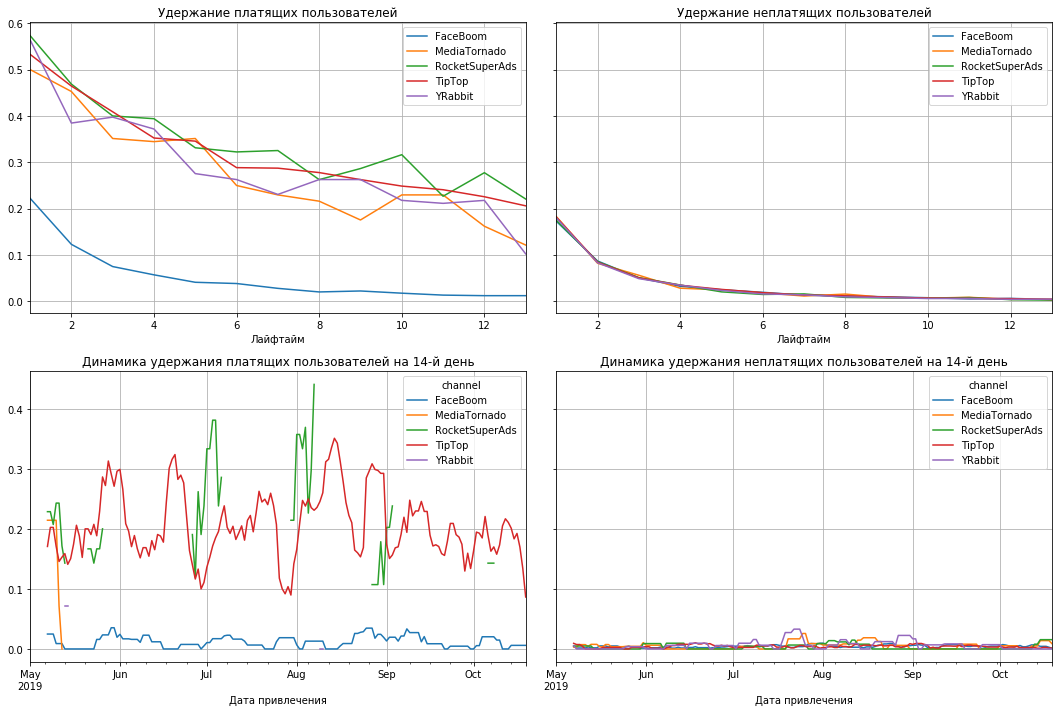

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    usa_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот удержание FaceBoom подкачало. Платящие пользователи практически вообще не возвращаются после первой покупки.

### Вывод

Реклама перестала окупаться в июле, примерно в тот момент, когда затраты на неё резко выросли. Можно предположить, что увеличение дохода на маркетинг не принесло того результата, какой планировали, то есть затраты увеличили, а прибыль не увеличилась.

Если говорить про устройства, то стоит обратить внимание на владельцев айофонов и маков. Стоимость их привлечения очень высокая, а профита нет. Стоимость их привлечения не окупается совсем.

По дальнейшим графикам видна резкая пропасть между пользователями из США и пользователями из других стран. Из всех пользователей не окупаются только США, тогда как Англия и Германия показывают хорошие результаты.

Если говорить отдельно про США, то можно сказать, что пользователи оттуда очень хорошо конвертируются, необычайно хорошо, значительно лучше всех остальных стран, но при этом практически не удерживаются, то есть не совершают повторную покупку.

По дальнейшим графикам с анализом США можно сделать предположение, что убыток в американском сегменте связан с непропорционально большими затратами на FaceBoom и TipTop, для которых характерно крайне низкое удержание клиентов, для FaceBoom это значение практически на нуле и гигантские затраты на привлечение пользователей TipTop.

## Выводы

### Причины неэффективности

Реклама не окупается к концу 2й недели. ROI — около 80%.CAC нестабилен. Рекламный бюджет увеличивается с течением времени. На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей. ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать до 0.6.
1. По устройствам: проблемы с пользователемя Mac и iPhone. Их уровень окупаемости стабильно держится на 60% с июля месяца, хотя в мае владельцы айфонов ещё окупались, как и владельцы андроид. А вот с июня они устремились вниз. Если предположить, что пользователи разных устройств распределены примерно равномерно, то может существовать некая техническая проблема с оплатой на этих устройствах.
2. У приложения FaceBoom проблемы с удержанием клиентов. Практически никто не совершает повторную покупку. Возможно, мы взяли слишком маленький горизонт анализа, и большее количество людей возвращаются с оплатой после двух недель пользования. С другой стороны, мне кажется это маловероятным. 
3. TipTop забирает в себя слишком много маркетингового бюджета, при этом не п

### Рекомендации для отдела маркетинга

По проведённому исследованию можно выделить следующие проблемные точки: 

1. США. Вся эта страна является проблемной точкой. Они - самый наш большой регион, при этом у них самые низкие показатели. Внутри страны можно попробовать перенаправить финансирование  с TipTop на, например, YRabbit, которые показывают хорошие результаты окупаемости, при этом их стоимость привлечения клиентов самая низкая среди всех остальных каналов. Так же можно обратить внимание на RocketSuperAds, у которых самая высокая конверсия среди всех каналов с небольшим объёмом финансирования и пользователей, и достаточно низкая стоимость привлечения клиентов.

2. Снова США. Они забирают на себя очень большой поток финансирования, в то время как у Англии и Германии показатели окупаемости значительно выше. Можно расширять пользовательскую базу в те страны.